In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.
C:\Users\tliev\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tliev\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tliev\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tliev\.conda\envs\TF\lib\site-packages\tensorflow\python

In [3]:
df = pd.read_csv("model_data.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        27140 non-null  int64  
 1   Date              27140 non-null  object 
 2   temp              27140 non-null  float64
 3   dewp              27140 non-null  float64
 4   slp               27140 non-null  float64
 5   visib             27140 non-null  float64
 6   wdsp              27140 non-null  float64
 7   max               27140 non-null  float64
 8   min               27140 non-null  float64
 9   fog               27140 non-null  float64
 10  rain_drizzle      27140 non-null  float64
 11  snow_ice_pellets  27140 non-null  float64
 12  hail              27140 non-null  float64
 13  thunder           27140 non-null  float64
 14  year sin          27140 non-null  float64
 15  year cos          27140 non-null  float64
dtypes: float64(14), int64(1), object(1)
memo

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        27140 non-null  int64  
 1   Date              27140 non-null  object 
 2   temp              27140 non-null  float64
 3   dewp              27140 non-null  float64
 4   slp               27140 non-null  float64
 5   visib             27140 non-null  float64
 6   wdsp              27140 non-null  float64
 7   max               27140 non-null  float64
 8   min               27140 non-null  float64
 9   fog               27140 non-null  float64
 10  rain_drizzle      27140 non-null  float64
 11  snow_ice_pellets  27140 non-null  float64
 12  hail              27140 non-null  float64
 13  thunder           27140 non-null  float64
 14  year sin          27140 non-null  float64
 15  year cos          27140 non-null  float64
dtypes: float64(14), int64(1), object(1)
memo

In [6]:
values = df.drop(["Date"], axis=1).values
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
series_to_supervised(scaled, 2, 1)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
2,0.000000,0.478950,0.551425,0.580982,0.372414,0.169381,0.469502,0.447147,0.0,0.0,...,0.221498,0.591092,0.662809,0.0,0.0,0.0,0.0,0.0,0.470697,0.000859
3,0.000037,0.593028,0.684015,0.558163,0.396552,0.351792,0.529695,0.596347,0.0,0.0,...,0.407166,0.577849,0.730627,0.0,1.0,0.0,0.0,0.0,0.462115,0.001437
4,0.000074,0.645994,0.775712,0.512520,0.362069,0.221498,0.591092,0.662809,0.0,0.0,...,0.315961,0.577849,0.608554,0.0,1.0,0.0,0.0,1.0,0.453544,0.002163
5,0.000111,0.666365,0.812887,0.455467,0.296552,0.407166,0.577849,0.730627,0.0,1.0,...,0.201954,0.615169,0.623474,1.0,1.0,0.0,0.0,0.0,0.444987,0.003036
6,0.000147,0.617474,0.686493,0.225357,0.324138,0.315961,0.577849,0.608554,0.0,1.0,...,0.192182,0.540530,0.703499,1.0,1.0,0.0,0.0,0.0,0.436447,0.004055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27135,0.999779,0.741602,0.658736,0.548273,0.320690,0.160261,0.701605,0.683425,0.0,0.0,...,0.067101,0.730979,0.658739,0.2,0.0,0.0,0.0,0.0,0.998481,0.461059
27136,0.999816,0.693526,0.696654,0.504913,0.315172,0.087296,0.705939,0.623745,0.0,0.0,...,0.103583,0.704254,0.739850,0.0,0.0,0.0,0.0,0.0,0.997738,0.452490
27137,0.999853,0.736170,0.759851,0.515562,0.297241,0.067101,0.730979,0.658739,0.2,0.0,...,0.106189,0.731461,0.715978,0.0,0.0,0.0,0.0,0.0,0.996847,0.443935
27138,0.999889,0.756813,0.784634,0.519367,0.311034,0.103583,0.704254,0.739850,0.0,0.0,...,0.102280,0.745425,0.680441,0.0,0.0,0.0,0.0,0.0,0.995809,0.435397


In [26]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]], axis=1, inplace=True)

In [27]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t)
1,0.000000,0.478950,0.551425,0.580982,0.372414,0.169381,0.469502,0.447147,0.0,0.0,0.0,0.0,0.0,0.487884,0.000147,0.000037
2,0.000037,0.593028,0.684015,0.558163,0.396552,0.351792,0.529695,0.596347,0.0,0.0,0.0,0.0,0.0,0.479287,0.000429,0.000074
3,0.000074,0.645994,0.775712,0.512520,0.362069,0.221498,0.591092,0.662809,0.0,0.0,0.0,0.0,0.0,0.470697,0.000859,0.000111
4,0.000111,0.666365,0.812887,0.455467,0.296552,0.407166,0.577849,0.730627,0.0,1.0,0.0,0.0,0.0,0.462115,0.001437,0.000147
5,0.000147,0.617474,0.686493,0.225357,0.324138,0.315961,0.577849,0.608554,0.0,1.0,0.0,0.0,1.0,0.453544,0.002163,0.000184


In [28]:
reframe_values = reframed.values
X = reframe_values[:,:-1]
y = reframe_values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [29]:
#early stopping
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(15))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam", metrics=["mse"])

history = model.fit(X_train, y_train, epochs=25, batch_size=60, validation_split=0.1, verbose=2, shuffle=False)

Train on 18318 samples, validate on 2036 samples
Epoch 1/25
 - 1s - loss: 0.0153 - mse: 4.7641e-04 - val_loss: 0.0593 - val_mse: 0.0041
Epoch 2/25
 - 1s - loss: 0.0324 - mse: 0.0081 - val_loss: 0.0489 - val_mse: 0.0028
Epoch 3/25
 - 1s - loss: 0.0333 - mse: 0.0094 - val_loss: 0.0282 - val_mse: 0.0011
Epoch 4/25
 - 1s - loss: 0.0352 - mse: 0.0108 - val_loss: 0.0274 - val_mse: 0.0011
Epoch 5/25
 - 1s - loss: 0.0339 - mse: 0.0100 - val_loss: 0.0359 - val_mse: 0.0016
Epoch 6/25
 - 1s - loss: 0.0344 - mse: 0.0106 - val_loss: 0.0297 - val_mse: 0.0012
Epoch 7/25
 - 1s - loss: 0.0388 - mse: 0.0128 - val_loss: 0.0310 - val_mse: 0.0012
Epoch 8/25
 - 1s - loss: 0.0345 - mse: 0.0109 - val_loss: 0.0210 - val_mse: 6.4760e-04
Epoch 9/25
 - 1s - loss: 0.0372 - mse: 0.0116 - val_loss: 0.0290 - val_mse: 0.0011
Epoch 10/25
 - 1s - loss: 0.0375 - mse: 0.0116 - val_loss: 0.0175 - val_mse: 4.5291e-04
Epoch 11/25
 - 1s - loss: 0.0366 - mse: 0.0113 - val_loss: 0.0215 - val_mse: 6.6019e-04
Epoch 12/25
 - 1s - 

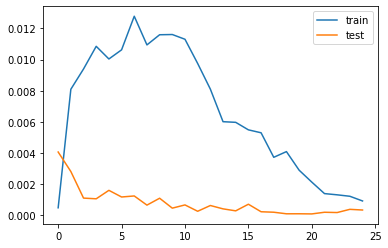

In [30]:
plt.plot(history.history["mse"], label="train")
plt.plot(history.history["val_mse"], label="test")
plt.legend()
plt.show()

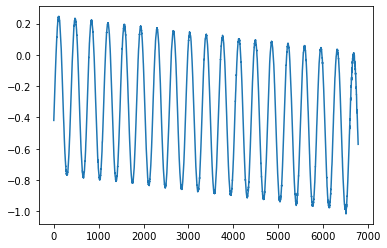

In [31]:
residual = pred - y_test
plt.plot(residual)

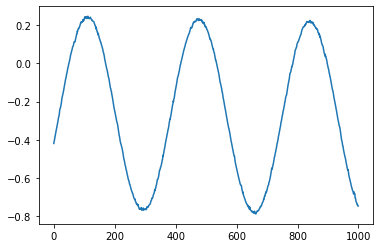

In [32]:
plt.plot(residual[0:1000])

In [16]:
pred = model.predict(X_test)
X_test_reshape = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv = np.concatenate((pred, X_test_reshape[:, 1:]), axis=1)



inv_scale = scaler.inverse_transform(inv)

y_inv = np.concatenate((y_test, X_test_reshape[:, 1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv

# y_test.shape
inv_scale[0].shape
# scaler.inverse_transform(pred)
predictions = pd.DataFrame({"Prediction": inv_scale[:,:1].flatten(), "Actual": y_inv[:,:1].flatten()})

ValueError: operands could not be broadcast together with shapes (6785,32) (15,) (6785,32) 

In [ ]:
predictions.head(50)